# Summary of extrinsic analysis

Input files for this notebook:

- file...

Output files from this notebook:

- file...

This notebook produces a quick overview of core results from the extrinsic results.

Only run this notebook once you have used a reference data set and successfully run the notebook for the [extrinsic analysis](./extrinsinc_analysis.ipynb).

For further information on how to use and interpret the different metrics, we refer to the original analysis notebook.

In [98]:
import geopandas as gpd
import osmnx as ox
import networkx as nx
import yaml
import matplotlib.pyplot as plt
import matplotlib as mpl
import contextily as cx
import json
import pickle
import pandas as pd 
import numpy as np
import os.path
from src import evaluation_functions as ef

### Load settings

In [2]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    
print('Settings loaded!')

Settings loaded!


### Load data

In [3]:
#osm_graph = ox.load_graphml(f'../data/osm_{study_area}.graphml')
osm_simplified_graph = ox.load_graphml(f'../data/osm_{study_area}_simple.graphml')

# Convert to nodes and edges
#osm_nodes, osm_edges = ox.graph_to_gdfs(osm_graph)
osm_simplified_nodes, osm_simplified_edges = ox.graph_to_gdfs(osm_simplified_graph)

# Load simplified and non-simplified graphs
#ref_graph = ox.load_graphml(f'../data/ref_{study_area}.graphml')
ref_simplified_graph = ox.load_graphml(f'../data/ref_{study_area}_simple.graphml')

# Convert to nodes and ref_edges
#ref_nodes, ref_edges = ox.graph_to_gdfs(ref_graph)
ref_simplified_nodes, ref_simplified_edges = ox.graph_to_gdfs(ref_simplified_graph)

print('Data loaded!')

Data loaded!


### Load results

In [4]:
with open(f'../results/extrinsic_analysis_{study_area}.json') as input_file:
    all_results = json.load(input_file)

with open(f'../results/grid_results_extrinsic_{study_area}.pickle', 'rb') as fp:
    grid = pickle.load(fp)

with open(f'../results/feature_matches_{study_area}.json') as input_file:
    fm_results = json.load(input_file)

with open(f'../results/grid_results_feature_matching_{study_area}.pickle', 'rb') as fp:
    grid_fm = pickle.load(fp)

### Styling settings

In [5]:
cell_hover = {
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}

row_hover = {
    'selector': 'tr:hover',
    'props': [('background-color', '#eff7fa')]
}

caption = {
    'selector': 'caption',
    'props': 'caption-side: top; font-size:2em;'
}

cell_style =  {
    'selector': 'td', 
    'props': 'text-align: center; font-weight: bold;'
}

# Styling setting for completeness results
index_name_completeness = {
    'selector': '.index_name',
    'props': 'color:white; font-weight:bold; background-color: orange; font-size:1.3em;'
}

columns_completeness = {
    'selector': 'th',
    'props': 'background-color: orange; color: white; font-weight:bold; font-size:1.3em;'
}

def format_completeness_style(styler):
    styler.set_caption('Network Completeness Quality Metrics')
    styler.format(precision=2, na_rep=' - ', thousands=',', formatter={'pct_difference': lambda x: f'{str(x)} %', 'normalised_values_pct_difference' : lambda x: f'{str(x)} %'})
    styler.set_table_styles([cell_hover, row_hover, columns_completeness, caption, index_name_completeness, cell_style], overwrite=False)
    styler.applymap_index(lambda v: 'color:white; font-style: italic; font-weight:bold; background-color: orange; font-size:1em;', axis=0)
    styler.applymap(ef.style_pct_value_completeness, osm_bigger='color:blue;',osm_smaller='color:green;')
    
    return styler


# Styling settings for topology results
index_name_topo = {
    'selector': '.index_name',
    'props': 'color:white; font-weight:bold; background-color: purple; font-size:1.3em;'
}

columns_topo = {
    'selector': 'th',
    'props': 'background-color: purple; color: white; font-weight:bold; font-size:1.3em;'
}

high_bad_topo = ['dangling_node_count','dangling_node_density_sqkm','component_count','component_gaps','count_overshoots','count_undershoots']
high_good_topo = ['largest_cc_pct_size','largest_cc_length_km','edge_component_ratio']

topo_slice_inverse = high_bad_topo,['pct_difference','normalised_values_pct_difference']
topo_slice = high_good_topo,['pct_difference','normalised_values_pct_difference']

def format_topology_style(styler):
    styler.set_caption('Network Topology Quality Metrics')
    styler.format(precision=2, na_rep=' - ', thousands=',', formatter={'pct_difference': lambda x: f'{str(x)} %', 'normalised_values_pct_difference' : lambda x: f'{str(x)} %'})
    styler.set_table_styles([cell_hover, row_hover, columns_topo, caption, index_name_topo, cell_style], overwrite=False)
    styler.applymap_index(lambda v: 'color:white; font-style: italic; font-weight:bold; background-color: purple; font-size:1em;', axis=0)
    styler.applymap(ef.style_pct_value, osm_better='color:blue;',osm_worse='color:green;',subset=topo_slice)
    styler.applymap(ef.style_pct_value_inversed, osm_better='color:blue;',osm_worse='color:green;',subset=topo_slice_inverse)
    
    return styler



## Global differences

Below, the global differences (i.e. metrics covering the whole study area) betweeen the two datasets are summarized.
The metrics are in this section categorised as either describing **network completeness** (for example network density) or **network topology** (for example connected component count).

In [6]:
osm_df = pd.DataFrame.from_dict(all_results['osm_results'], orient='index')
ref_df = pd.DataFrame.from_dict(all_results['ref_results'], orient='index')

osm_df.rename(columns={0:'OSM'},inplace=True)
ref_df.rename(columns={0:'reference'}, inplace=True)

combined_results = pd.concat([osm_df, ref_df], axis=1)

combined_results = combined_results.round(2)

combined_results['pct_difference'] = combined_results.apply( lambda x: ef.find_pct_diff(x, 'OSM', 'reference'), axis=1)

select_completeness_results = ['node_count', 'edge_count', 'edge_density_m_sqkm', 'node_density_sqkm',
       'protected_density_m_sqkm','unprotected_density_m_sqkm', 'mixed_density_m_sqkm']
       
completeness_results = combined_results.loc[select_completeness_results]

completeness_results.index.name = 'Quality Metrics'

select_topology_results = ['dangling_node_count','dangling_node_density_sqkm', 
       'simplified_edge_pct_diff', 'simplified_node_pct_diff', 'edges_pr_km',
       'nodes_pr_km', 'alpha', 'beta', 'gamma', 'component_count',
       'largest_cc_pct_size', 'largest_cc_length_km', 'component_gaps',
       'count_overshoots', 'count_undershoots',
       'edge_component_ratio']
       
topology_results = combined_results.loc[select_topology_results]

topology_results['OSM_normalised'] = topology_results.OSM / (osm_simplified_edges.length.sum()/1000)

topology_results['reference_normalised'] = topology_results.reference / (ref_simplified_edges.length.sum()/1000)

topology_results['normalised_values_pct_difference'] = topology_results.apply( lambda x: ef.find_pct_diff(x, 'OSM_normalised','reference_normalised'), axis=1)

# Some values cannot meaningfully be normalised per network length
topology_results.loc[['largest_cc_pct_size','alpha', 'beta','gamma'],['OSM_normalised','reference_normalised']] = None

topology_results.index.name = 'Quality Metrics'

### Network completeness

In the table below, values are colored based on whether the results indicate a more complete dataset in the OSM data (<span style='color:blue'>blue</span>) or in the reference data (<span style='color:green'>green</span>).

Whether differences in the coverage or completeness of the data are due to errors of omission or commission requires further analysis - and ideally familiarity with the study area. In the interpretation we assume differences in network density etc. to be due to errors of comisssion - but if you know that this assumption is false for your study area, the interpretation of differences in largest component etc. should of course be adjusted.

In [52]:
completeness_results.style.pipe(format_completeness_style)

,OSM,reference,pct_difference
Quality Metrics,,,
node_count,"4,725.00","3,655.00",25.54 %
edge_count,"5,479.00","4,208.00",26.24 %
edge_density_m_sqkm,"5,869.44","3,437.55",52.26 %
node_density_sqkm,26.05,20.15,25.54 %
protected_density_m_sqkm,"5,303.09","2,996.63",55.58 %
unprotected_density_m_sqkm,514.78,440.92,15.46 %
mixed_density_m_sqkm,51.40,-,-


### Network topology

When comparing the values for respectively the OSM and the reference data, the value for the OSM data is taken as the basis, to which the value for the reference data is compared. In the columns computing the percentual difference, positive values thus means that the original metric value is highest for the OSM data, while negative value for pct difference means that the metric value is highest for the reference data.

In the table below, values are colored based on whether the results indicate a higher quality for the OSM data (<span style='color:blue'>blue</span>) or the reference data (<span style='color:green'>green</span>). For some metrics, a high value indicates high quality - e.g. how many percent of the network is included in the largest component or the edge/component ratio, while it for other metrics indicates lower quality (e.g. the number of overshoots).

To account for differences in the extent of the network, the column contains two columns comparing the OSM and the reference data: One comparing the original values ('pct_diff') and one comparing the metric value per kilometer of edges. In this way, we account for e.g. situations where a higher number of potential topological differences in a dataset might be explained by that dataset covering much more infrastructure.

For some metrics - such as the number of edges per kilometer or the difference in node count between the simplified and non-simplified graphs - we cannot judge whether high or low values are an indication of data quality, without further inspection.

In the interpretation of some metrics - e.g. the length of the largest component - we assume that the dataset with more kilometers mapped is the correct one (i.e. we assume that in case of differences, it is a case of ommission by the smaller dataset, not a case of commission by the larger one). If you know that this assumption is false for your study area, the interpretation of differences in largest component etc. should of course be adjusted.

In [53]:
topology_results.style.pipe(format_topology_style)

,OSM,reference,pct_difference,OSM_normalised,reference_normalised,normalised_values_pct_difference
Quality Metrics,,,,,,
dangling_node_count,"1,785.00",872.00,68.72 %,2.21,1.40,44.99 %
dangling_node_density_sqkm,9.84,4.81,68.67 %,0.01,0.01,44.93 %
simplified_edge_pct_diff,82.48,60.18,31.26 %,0.10,0.10,5.65 %
simplified_node_pct_diff,84.52,63.50,28.4 %,0.10,0.10,2.73 %
edges_pr_km,5.15,6.75,-26.89 %,0.01,0.01,-51.72 %
nodes_pr_km,4.44,5.86,-27.57 %,0.01,0.01,-52.37 %
alpha,0.08,0.08,0.0 %,-,-,-25.72 %
beta,1.16,1.15,0.87 %,-,-,-24.87 %
gamma,0.39,0.38,2.6 %,-,-,-23.17 %


## Local differences

Differences in global values for the quality metrics will be the most important aspect when assessing fitness for use for most use cases. An important feature of VGI data and data quality is however that data quality and the presence of errors and inaccuraries are not randomly distributed, but often show some type of spatial autocorrelation. Therefore, it is also of interest to identify any local patterns in data completeness and quality.

To aid in the interpretation of local variation in data quality, we map the local calculations of data quality in 3 differens 'small multiples' plots covering *completeness*, *data structure & topology*, and the results from the analysis of *network components*.

### Completeness

#### Interpretation

ADD HERE

To make the comparisons of the plots easier to interpret, the cell values are visualised using the same equal interval classification. Equal interval classifications have same drawbacks when it comes to...

What do the plots contain?
Grey for missing values


In [228]:
def get_equal_interval_bins(min_value, max_value, num_levels):

    step_size = (abs(min_value) + max_value ) / num_levels

    if step_size > 100:
        step_size = round(step_size,-2)

    elif step_size < 100:
        step_size = round(step_size,-1)

    step_size = round(step_size,)

    if step_size > 0:

        if min_value < 0:

            bins = []

            bin_level = None

            for i in range(num_levels):

                if bin_level is None:
               
                    bin_level = min_value + step_size

                else: 
                    bin_level += step_size

                if bin_level > 100:
                    bin_level = round(bin_level,-2)

                else:
                    bin_level = round(bin_level,-1)

                bins.append(bin_level)
    
        else:
            bins = []

            for i in range(num_levels):
                bins.append((i+1)*step_size)

        return bins


def create_color_scale_around_midpoint(num_levels, vmin, vmax, colorscale='seismic', midpoint=0):

    #levels = np.linspace(vmin, vmax, num_levels)
    levels = get_equal_interval_bins(vmin, vmax, num_levels)

    midp = np.mean(np.c_[levels[:-1], levels[1:]], axis=1)
    vals = np.interp(midp, [vmin, midpoint, vmax], [0, 0.5, 1])
    colors = plt.cm.get_cmap(colorscale)(vals)
    cmap, norm = mpl.colors.from_levels_and_colors(levels, colors)

    return cmap, norm


/opt/miniconda3/envs/cdq/lib/python3.10/site-packages/mapclassify/classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


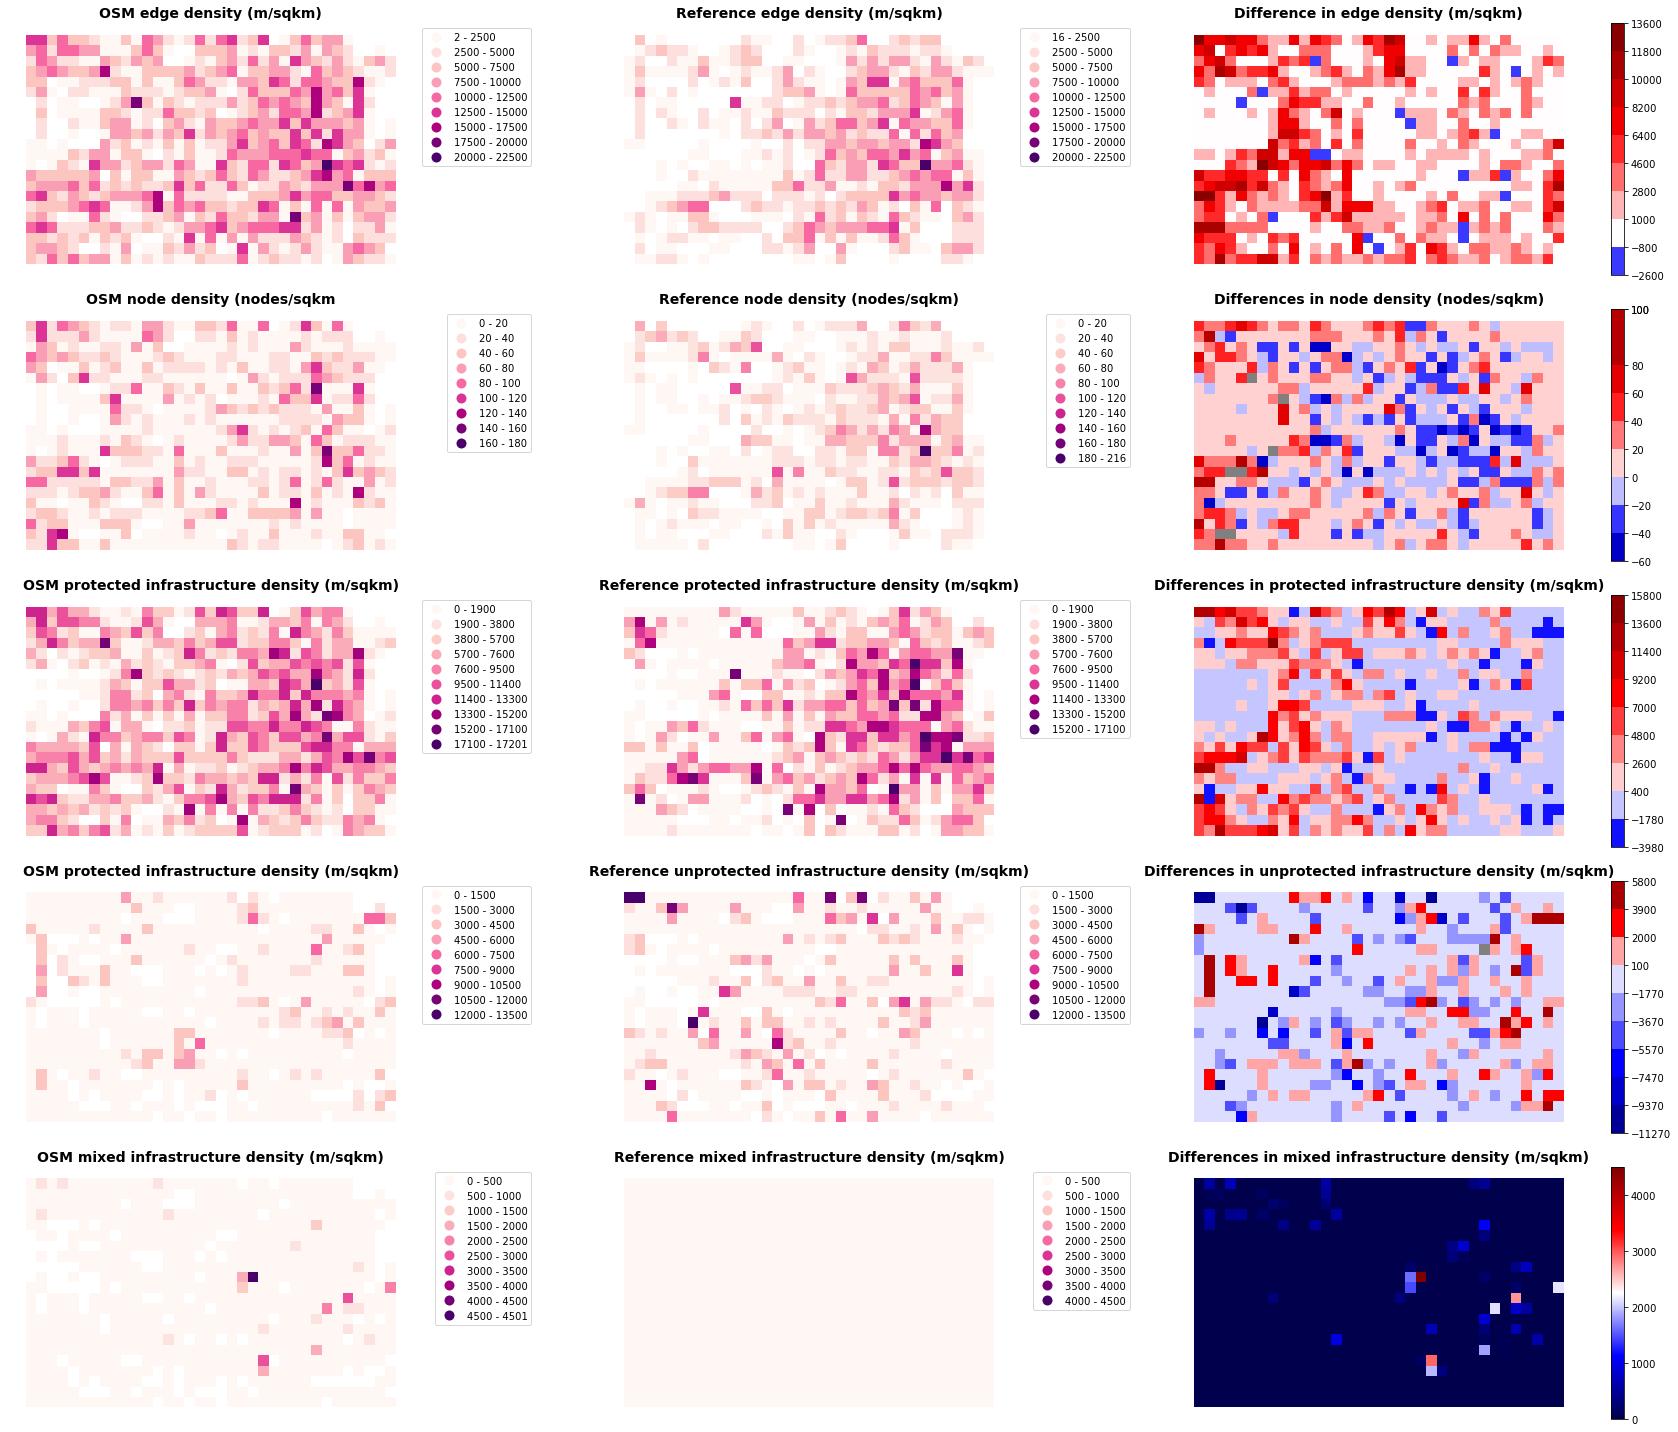

In [327]:
fig_completeness, axes = plt.subplots(nrows=5,ncols=3, figsize=(25,20))

axes = axes.flatten()

plot_cols = [
    'osm_edge_density','ref_edge_density','edge_density_diff',
    'osm_node_density','ref_node_density','node_density_diff',
    'osm_protected_density','ref_protected_density', 'protected_density_diff',
    'osm_unprotected_density','ref_unprotected_density','unprotected_density_diff',
    'osm_mixed_density','ref_mixed_density','mixed_density_diff'
    ]

titles = [
    'OSM edge density (m/sqkm)', 'Reference edge density (m/sqkm)', 'Difference in edge density (m/sqkm)',
    'OSM node density (nodes/sqkm', 'Reference node density (nodes/sqkm)', 'Differences in node density (nodes/sqkm)',
    'OSM protected infrastructure density (m/sqkm)', 'Reference protected infrastructure density (m/sqkm)', 'Differences in protected infrastructure density (m/sqkm)',
    'OSM unprotected infrastructure density (m/sqkm)','Reference unprotected infrastructure density (m/sqkm)', 'Differences in unprotected infrastructure density (m/sqkm)',
    'OSM mixed infrastructure density (m/sqkm)', 'Reference mixed infrastructure density (m/sqkm)', 'Differences in mixed infrastructure density (m/sqkm)'
    ]

cmap_diff = 'seismic' #'Wistia'
cmap_abs = 'RdPu'

for i, c in enumerate(plot_cols):
    ax = axes[i]
    ax.set_axis_off()

    num_levels = 10

    if i in [2, 5, 8, 11, 14] and grid[c].min() < 0:

        cmap, norm = create_color_scale_around_midpoint(num_levels=num_levels, vmin=grid[c].min(),vmax=grid[c].max(), colorscale=cmap_diff)

        # Add grey to a colormap to represent missing value
        cmap_list = [mpl.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]
        cmap_list.append('grey')
        cmap_with_grey = mpl.colors.ListedColormap(cmap_list)

        grid.plot(column= c, ax=ax, norm = norm, cmap = cmap_with_grey, legend=True)

    elif i in [2, 5, 8, 11, 14] and grid[c].min() >= 0:
        grid.plot(column= c, ax=ax, cmap = cmap_diff, legend=True)

    else:
        # Create uniform bins OSM and reference plots
        if i in [0,3,6,9,12]:
            max_value = max(grid[c].max(),grid[plot_cols[i+1]].max())
            min_value = min(grid[c].min(),grid[plot_cols[i+1]].min())

        else:
            max_value = max(grid[c].max(),grid[plot_cols[i-1]].max())
            min_value = min(grid[c].min(),grid[plot_cols[i-1]].min())

        bins = get_equal_interval_bins(min_value, max_value, num_levels-1)


        grid.plot(column=c, ax=ax, legend=True, scheme='user_defined', classification_kwds={'bins':bins}, cmap=cmap_abs)

        leg = ax.get_legend()
        leg.set_bbox_to_anchor((1.3, 1.))
        leg.get_frame().set_facecolor('none')

        for lbl in leg.get_texts():

            label_text = lbl.get_text()
            lower = label_text.split()[0]
            lower = lower[:-1]
            upper = label_text.split()[1]
            new_text = f'{float(lower):.0f} - {float(upper):.0f}'
            lbl.set_text(new_text)
                        
    ax.set_title(titles[i],  {'fontsize': 14,'fontweight': 'bold'})

plt.tight_layout()


### Structure & Topology

#### Interpretation

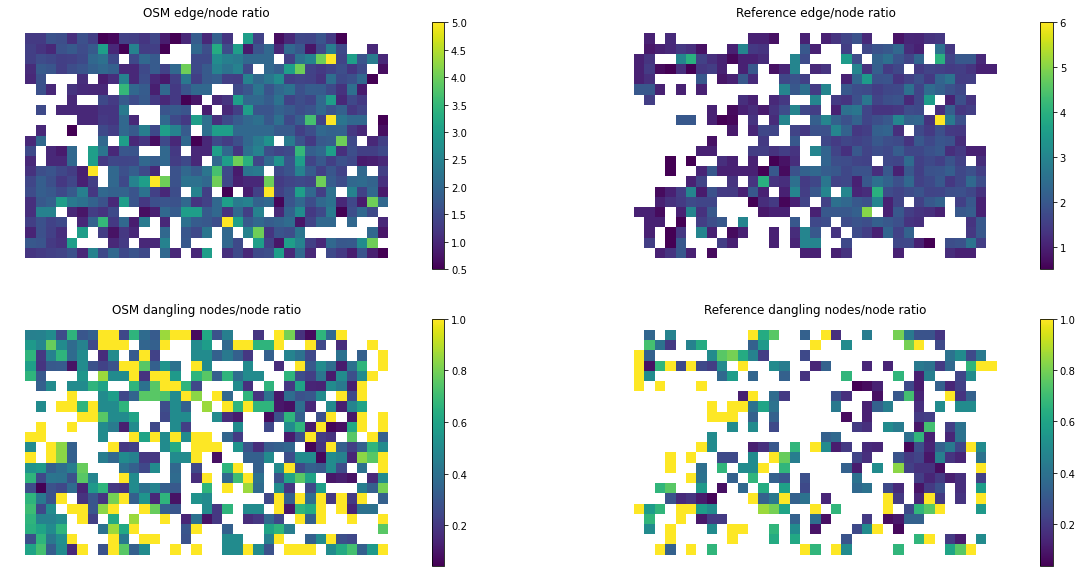

In [92]:
fig_structure, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,10))

axes = axes.flatten()

plot_cols = [
    'osm_edge_node_ratio', 'ref_edge_node_ratio',
    'osm_dangling_nodes_per_node','ref_dangling_nodes_per_node'   
    ]

titles = ['OSM edge/node ratio', 'Reference edge/node ratio',
    'OSM dangling nodes/node ratio','Reference dangling nodes/node ratio'  
    ]

for i, c in enumerate(plot_cols):
    ax = axes[i]
    ax.set_axis_off()
    grid.plot(column=c, ax=ax, legend=True)
    ax.set_title(titles[i])

plt.tight_layout()


# TODO: 
    # Use uniform bins, 
    # change color scheme
    # format titles


### Components

#### Interpretation

ADD HERE

In [ ]:
# Plot all components

# Plot component issues

# Plot cells with more than one components

# Plot cell reach

In [ ]:
def plot_components(components):

    #Plot components with each their color
    fig, ax = plt.subplots(figsize=(20,20))

    for c in components:
        rgb = np.random.rand(3,)
        if len(c.edges) > 0:
            edges = ox.graph_to_gdfs(c, nodes=False)
    
            edges.plot(ax=ax, color=rgb)
            
    ax.set_title('Connected components')
    plt.show()

    return fig

In [ ]:
# TODO: Compare plots of unconnected issues!

osm_components = ef.return_components(osm_simplified_graph)
print(f'The OSM network in the study area consists of {len(osm_components)} unconnected components.')

components_plot = ef.plot_components(osm_components)


ref_components = ef.return_components(ref_simplified_graph)
print(f'The reference network in the study area consists of {len(ref_components)} unconnected components.')

components_plot = ef.plot_components(ref_components)


In [ ]:
# TODO: Compare plots of unconnected issues!

osm_components = ef.return_components(osm_simplified_graph)
print(f'The OSM network in the study area consists of {len(osm_components)} unconnected components.')

components_plot = ef.plot_components(osm_components)

osm_comp_issues = ef.find_adjacent_components(components=osm_components, buffer_dist=10, crs=study_crs)

fig, ax = plt.subplots(figsize=(20,20))

osm_simplified_edges.plot(ax=ax, color='grey');
osm_comp_issues.plot(ax=ax, color='red', linewidth=2);

# TODO: Fix plot - plot with unconnected components as well

ref_components = ef.return_components(ref_simplified_graph)
print(f'The reference network in the study area consists of {len(ref_components)} unconnected components.')

components_plot = ef.plot_components(ref_components)

ref_comp_issues = ef.find_adjacent_components(components=ref_components, buffer_dist=10, crs=study_crs)

fig, ax = plt.subplots(figsize=(20,20))

ref_simplified_edges.plot(ax=ax, color='grey');
ref_comp_issues.plot(ax=ax, color='red', linewidth=2);

# TODO: Fix plot - plot with unconnected ref_components as well

### Feature Matching

#### Interpretation

ADD HERE

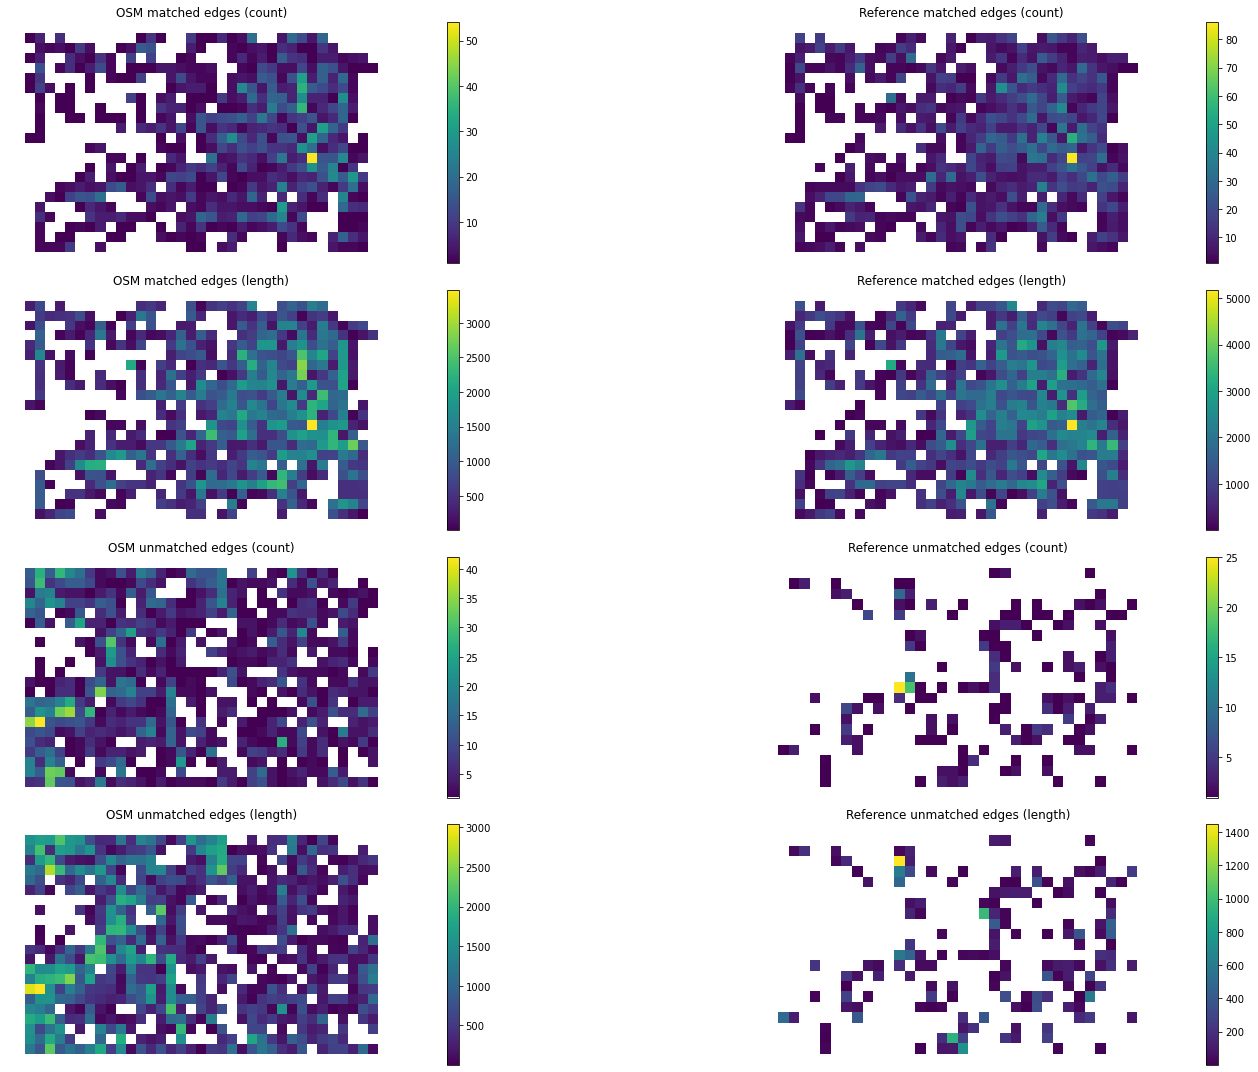

In [96]:
fig_feature_matching, axes = plt.subplots(nrows=4,ncols=2, figsize=(25,15))

axes = axes.flatten()

plot_cols = [
    'count_osm_matched', 'count_ref_matched',
    'length_osm_matched', 'length_ref_matched',
    'count_osm_unmatched', 'count_ref_unmatched',
    'length_osm_unmatched', 'length_ref_unmatched']

titles = [
    'OSM matched edges (count)', 'Reference matched edges (count)',
    'OSM matched edges (length)', 'Reference matched edges (length)',
    'OSM unmatched edges (count)', 'Reference unmatched edges (count)',
    'OSM unmatched edges (length)', 'Reference unmatched edges (length)',
    ]

for i, c in enumerate(plot_cols):
    ax = axes[i]
    ax.set_axis_off()
    grid_fm.plot(column=c, ax=ax, legend=True)
    ax.set_title(titles[i])


plt.tight_layout()

# TODO: 
    # Use uniform bins, 
    # change color scheme
    # format titles

## Export plots

In [ ]:
# Export results

# plots to save